<h1 align="center">EECS E6893 Big Data Analytics - Homework Assignment 1</h1>
<h2 align="center">Name: Qi Wang</h2>
<h2 align="center">UNI: qw2261</h2>



In [1]:
import operator
import sys
from pyspark import SparkConf, SparkContext
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

In [2]:
# Macros.
MAX_ITER = 20
DATA_PATH = "gs://homework0_qi/HW1/data.txt"
C1_PATH = "gs://homework0_qi/HW1/c1.txt"
C2_PATH = "gs://homework0_qi/HW1/c2.txt"
NORM = 2

In [3]:
# Spark settings
# conf = SparkConf()
sc = SparkContext.getOrCreate()

In [4]:
# Load the data, cache this since we're accessing this each iteration
data = sc.textFile(DATA_PATH).map(
        lambda line: np.array([float(x) for x in line.split(' ')])
        ).cache()
# Load the initial centroids c1, split into a list of np arrays
centroids1 = sc.textFile(C1_PATH).map(
        lambda line: np.array([float(x) for x in line.split(' ')])
        ).collect()
# Load the initial centroids c2, split into a list of np arrays
centroids2 = sc.textFile(C2_PATH).map(
        lambda line: np.array([float(x) for x in line.split(' ')])
        ).collect()

In [5]:
# Helper functions.
def closest(p, centroids, norm):
    """
    Compute closest centroid for a given point.
    Args:
        p (numpy.ndarray): input point
        centroids (list): A list of centroids points
        norm (int): 1 or 2
    Returns:
        int: The index of closest centroid.
    """
    closest_c = min([(i, linalg.norm(p - c, norm))
                    for i, c in enumerate(centroids)],
                    key=operator.itemgetter(1))[0]
    return closest_c

In [6]:
# K-means clustering
def kmeans(data, centroids, norm=2):
    """
    Conduct k-means clustering given data and centroid.
    This is the basic version of k-means, you might need more
    code to record cluster assignment to plot TSNE, and more
    data structure to record cost.
    Args:
        data (RDD): RDD of points
        centroids (list): A list of centroids points
        norm (int): 1 or 2
    Returns:
        RDD: assignment information of points, a RDD of (centroid, (point, 1))
        list: a list of centroids
        and define yourself...
    """
    # iterative k-means
    within_cluster_cost = []
    training_data = data.collect()
    
    for _ in range(MAX_ITER):
        iter_cost = 0
        
        combo_points = []
        # Transform each point to a combo of point, closest centroid, count=1
        # point -> (closest_centroid, (point, 1))
        for point in training_data:
            closest_centroid = closest(point, centroids, norm)
            combo_points.append((closest_centroid, (point, 1)))
                    
        for each_combo in combo_points:
            single_part = (linalg.norm(each_combo[1][0] - centroids[each_combo[0]], norm))
            if norm == 2:
                single_part = single_part ** 2
            iter_cost += single_part
            
        print(iter_cost)
        within_cluster_cost.append(iter_cost)
        
        
        # Re-compute cluster center
        # For each cluster center (key), aggregate its values
        # by summing up points and count
        combo_points_rdd = sc.parallelize(combo_points)
        combo_points_rdd = combo_points_rdd.reduceByKey(lambda v1, v2: (v1[0] + v2[0], v1[1] + v2[1]))
        
        
        # Average the points for each centroid: divide sum of points by count
        combo_points_rdd = combo_points_rdd.map(lambda v: (v[0], (v[1][0] / v[1][1], v[1][1])))

        # Use collect() to turn RDD into list
        updated_centroids = []
        for each_centroid in combo_points_rdd.sortByKey().collect():
            updated_centroids.append(each_centroid[1][0])
        
        centroids = updated_centroids
    
    
    return_combo = sc.parallelize(combo_points)
    return return_combo, centroids, within_cluster_cost

# Question one

## (1). Using L1 distance as similarity measurement

In [7]:
L1_c1_combo, L1_c1_centroid, L1_c1_wc_cost = kmeans(data, centroids1, norm=1)

550117.1420000045
464829.2684039464
470934.15384668263
483874.81628509297
489234.2347883483
487664.6926267901
483718.66592851654
475337.94763305597
474871.9665496577
457244.78974174923
447493.195604051
450891.8358047716
451232.5774756949
451860.12588546367
451567.2235891512
452710.0520999444
453078.22696184984
450646.13556209765
450419.97011343326
449009.59037188475


In [8]:
L1_c2_combo, L1_c2_centroid, L1_c2_wc_cost = kmeans(data, centroids2, norm=1)

1433739.3099999938
1084488.7769648738
973431.7146620394
895934.5925630673
865128.3352940796
845846.6470313473
827219.5827561237
803590.3456011107
756039.5172761244
717332.9025432297
694587.9252526845
684444.5019967925
674574.7475478566
667409.469916026
663556.6278214998
660162.777228758
656041.3222947085
653036.7540731638
651112.4262522653
649689.0131843556


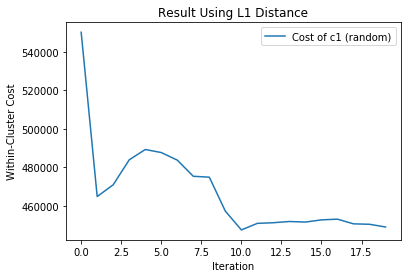

In [9]:
x = range(20)
plt.plot(x, L1_c1_wc_cost)
plt.legend(['Cost of c1 (random)'])
plt.title("Result Using L1 Distance")
plt.xlabel('Iteration')
plt.ylabel('Within-Cluster Cost')
plt.show()

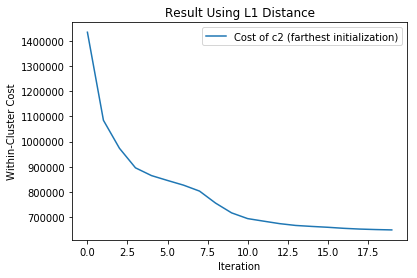

In [10]:
x = range(20)
plt.plot(x, L1_c2_wc_cost)
plt.legend(['Cost of c2 (farthest initialization)'])
plt.title("Result Using L1 Distance")
plt.xlabel('Iteration')
plt.ylabel('Within-Cluster Cost')
plt.show()

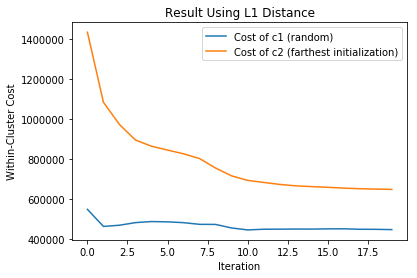

In [11]:
x = range(20)
plt.plot(x, L1_c1_wc_cost)
plt.plot(x, L1_c2_wc_cost)
plt.legend(['Cost of c1 (random)', 'Cost of c2 (farthest initialization)'])
plt.title("Result Using L1 Distance")
plt.xlabel('Iteration')
plt.ylabel('Within-Cluster Cost')
plt.show()

## (2). Using L2 distance as similarity measurement

In [12]:
L2_c1_combo, L2_c1_centroid, L2_c1_wc_cost = kmeans(data, centroids1, norm=2)

623660345.306
509862908.298
485480681.872
463997011.685
460969266.573
460537847.983
460313099.654
460003523.889
459570539.318
459021103.342
458490656.192
457944232.588
457558005.199
457290136.352
457050555.06
456892235.615
456703630.737
456404203.019
456177800.542
455986871.027


In [13]:
L2_c2_combo, L2_c2_centroid, L2_c2_wc_cost = kmeans(data, centroids2, norm=2)

438747790.028
249803933.626
194494814.406
169804841.452
156295748.806
149094208.109
142508531.62
132303869.407
117170969.837
108547377.179
102237203.318
98278015.7498
95630226.1218
93793314.0512
92377131.9682
91541606.2542
91045573.8304
90752240.1014
90470170.1812
90216416.1756


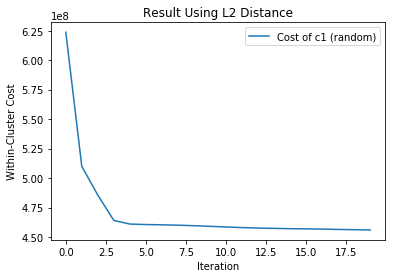

In [14]:
x = range(20)
plt.plot(x, L2_c1_wc_cost)
plt.legend(['Cost of c1 (random)'])
plt.title("Result Using L2 Distance")
plt.xlabel('Iteration')
plt.ylabel('Within-Cluster Cost')
plt.show()

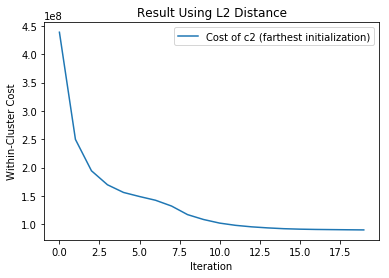

In [15]:
x = range(20)
plt.plot(x, L2_c2_wc_cost)
plt.legend(['Cost of c2 (farthest initialization)'])
plt.title("Result Using L2 Distance")
plt.xlabel('Iteration')
plt.ylabel('Within-Cluster Cost')
plt.show()

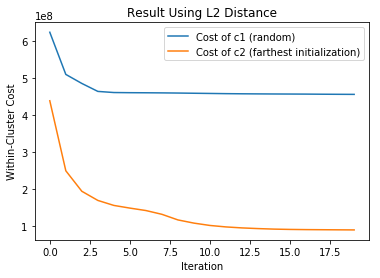

In [16]:
x = range(20)
plt.plot(x, L2_c1_wc_cost)
plt.plot(x, L2_c2_wc_cost)
plt.legend(['Cost of c1 (random)', 'Cost of c2 (farthest initialization)'])
plt.title("Result Using L2 Distance")
plt.xlabel('Iteration')
plt.ylabel('Within-Cluster Cost')
plt.show()

## (3). T-SNE reduction and visualizing the clustering of result (2) in 2D space

In [17]:
from sklearn.manifold import TSNE

In [18]:
## Help function to visualize the clustering situation
def T_SNE_graph(combo_points, random_seed, init_cluster):
    """
    Conduct T-SNE reduction for points
    to 2D space and visualize the clustering 
    result in the graph.
    Args:
        combo_points (RDD): a RDD of (centroid, (point, 1))
    Returns:
        T_SNE_plot: a plot of clustering in 2D space
    """
    labels = np.array(combo_points.map(lambda v: v[0]).collect())
    points = np.array(combo_points.map(lambda v: v[1][0]).collect())
    points_embbed = TSNE(n_components = 2, random_state = random_seed).fit_transform(points)
    print('Shape: ' + str(points.shape) + ' -> ' + str(points_embbed.shape))
    
    plt.figure()
    plt.scatter(points_embbed[:, 0], points_embbed[:, 1])
    plt.title('%s Before Clustering' % init_cluster)

    T_SNE_plot = plt.figure()
    plt.scatter(points_embbed[:, 0], points_embbed[:, 1], c = labels)
    plt.title('%s After Clustering' % init_cluster)
    plt.show()
    return T_SNE_plot

In [19]:
random_seed_given = np.random.randint(10)
random_seed_given

2

Shape: (4601, 58) -> (4601, 2)


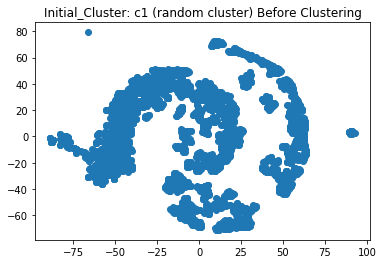

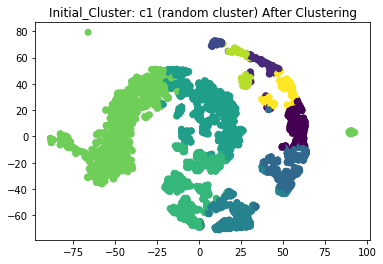

In [20]:
t_sne_c1 = T_SNE_graph(L2_c1_combo, random_seed_given, 'Initial_Cluster: c1 (random cluster)')

Shape: (4601, 58) -> (4601, 2)


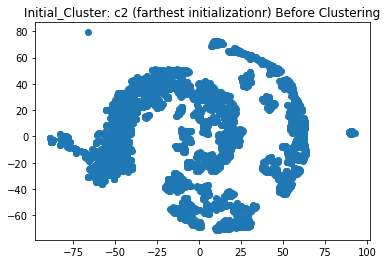

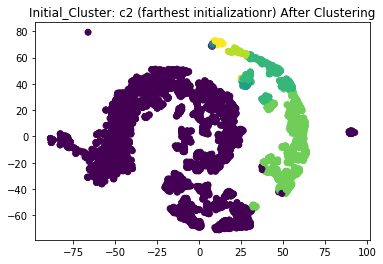

In [21]:
t_sne_c2 = T_SNE_graph(L2_c2_combo, random_seed_given, 'Initial_Cluster: c2 (farthest initializationr)')

## (4). Determine performance of K-means initialization using c1.txt and c2.txt for L1 and L2

In [22]:
(L1_c1_wc_cost[0] - L1_c1_wc_cost[-1]) / L1_c1_wc_cost[0]

0.1837927668651324

In [23]:
(L1_c2_wc_cost[0] - L1_c2_wc_cost[-1]) / L1_c2_wc_cost[0]

0.5468569434813374

**In terms of L1**, c1 improves by 18.38% and c2 improves by 54.69%. However, c1 reaches the smaller cost than c2.

**Based on my analysis, the metric of selecting centroids that are farthest is the better method, which means that c2 should be better than c1.**

**In this situation, the result displays that c1 is better than c2**, which might result from the case that the "farthest" is based on Euclidean metrics rather than Manhattan metric and the "farthest" in Euclidean might not be real farthest in Manhattan.

If we need the real farthest, we should select farthest centroids based on Manhattan metric and do K-means again for comparison.

In [24]:
(L2_c1_wc_cost[0] - L2_c1_wc_cost[-1]) / L2_c1_wc_cost[0]

0.26885383292518295

In [25]:
(L2_c2_wc_cost[0] - L2_c2_wc_cost[-1]) / L2_c2_wc_cost[0]

0.7943775029159899

**In terms of L2**, c1 improves by 26.9% after 20 iterations and c2 improves by 79.4% after 20 iterations. Also, c2 reaches the smaller cost than c1. 

Therefore, **c2 is better than c1 in terms of L2** because it distributes the initial clsuters far apart. There will be less overlap between points and the clusters are more obviously split, reaching a better result instance. 

## (5). The time complexity of iterative K-means

Assume a fixed number $t$ of iterations, for $n$ ($d$-dimensional) points, where $k$ is the number of centroids (or clusters), $Time\ Complexity = O(t\times k\times n\times d) = O(tknd)$

# Question two: Binary classification with Spark MLlib

## (1). Read the csv and rename the columns

In [26]:
import operator
from pyspark.sql import SparkSession

In [27]:
## Spark settings
spark = SparkSession.builder.appName('adult').getOrCreate()

In [28]:
adult_PATH = 'gs://homework0_qi/HW1/adult.csv'

In [29]:
## Read the csv file
df = spark.read.format("csv").options(header='false', inferschema='true').load(adult_PATH)
type(df)

pyspark.sql.dataframe.DataFrame

In [30]:
## Rename the columns
original_columns = df.columns
updated_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
                   'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
                   'hours_per_week', 'native_country', 'income']


print('Original DataFrame is ', df)
print('')

for i in range(len(original_columns)):
    df = df.withColumnRenamed(original_columns[i], updated_columns[i])

print('Updated DataFrame is ', df)
print('')

('Original DataFrame is ', DataFrame[_c0: int, _c1: string, _c2: double, _c3: string, _c4: double, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: double, _c11: double, _c12: double, _c13: string, _c14: string])

('Updated DataFrame is ', DataFrame[age: int, workclass: string, fnlwgt: double, education: string, education_num: double, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: double, capital_loss: double, hours_per_week: double, native_country: string, income: string])



## (2). Data preprocessing

In [31]:
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

In [32]:
df.show(1)

+---+----------+-------+----------+-------------+--------------+-------------+--------------+------+-----+------------+------------+--------------+--------------+------+
|age| workclass| fnlwgt| education|education_num|marital_status|   occupation|  relationship|  race|  sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+----------+-------+----------+-------------+--------------+-------------+--------------+------+-----+------------+------------+--------------+--------------+------+
| 39| State-gov|77516.0| Bachelors|         13.0| Never-married| Adm-clerical| Not-in-family| White| Male|      2174.0|         0.0|          40.0| United-States| <=50K|
+---+----------+-------+----------+-------------+--------------+-------------+--------------+------+-----+------------+------------+--------------+--------------+------+
only showing top 1 row



In [33]:
df.count()

32561

In [34]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



In [35]:
all_string_columns = ['workclass', 'education', 'marital_status', 'occupation', 
                      'relationship', 'race', 'sex', 'native_country', 'income']

In [36]:
def dataPreprocessing(df, string_column):
    index_output = string_column + 'Index'
    vec_output = string_column + 'Vec'
    
    indexer = StringIndexer(inputCol = string_column, outputCol = index_output)
    df = indexer.fit(df).transform(df)
    
    encoder = OneHotEncoderEstimator(inputCols = [index_output], outputCols = [vec_output])
    df = encoder.fit(df).transform(df)
    
    return df
    

In [37]:
df_clean = df
for each_string_column in all_string_columns:
    df_clean = dataPreprocessing(df_clean, each_string_column)

In [38]:
df_clean.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- workclassIndex: double (nullable = false)
 |-- workclassVec: vector (nullable = true)
 |-- educationIndex: double (nullable = false)
 |-- educationVec: vector (nullable = true)
 |-- marital_statusIndex: double (nullable = false)
 |-- marital_statusVec: vector (nullable = true)
 |-- occupationIndex: double (nullable = false)
 |-- occupationVec: vector (nullable = tru

In [39]:
## Assemble the vectors
input_col = ['age', 'workclassVec', 'fnlwgt', 'education_num', 'marital_statusVec',
             'occupationVec', 'relationshipVec', 'raceVec', 'sexVec', 'capital_gain',
             'capital_loss', 'hours_per_week', 'native_countryVec']
assembler = VectorAssembler(inputCols = input_col, outputCol = 'feature')

df_clean = assembler.transform(df_clean)

In [40]:
df_clean.select(['feature', 'incomeIndex']).show()

+--------------------+-----------+
|             feature|incomeIndex|
+--------------------+-----------+
|(85,[0,5,9,10,12,...|        0.0|
|(85,[0,2,9,10,11,...|        0.0|
|(85,[0,1,9,10,13,...|        0.0|
|(85,[0,1,9,10,11,...|        0.0|
|(85,[0,1,9,10,11,...|        0.0|
|(85,[0,1,9,10,11,...|        0.0|
|(85,[0,1,9,10,16,...|        0.0|
|(85,[0,2,9,10,11,...|        1.0|
|(85,[0,1,9,10,12,...|        1.0|
|(85,[0,1,9,10,11,...|        1.0|
|(85,[0,1,9,10,11,...|        1.0|
|(85,[0,5,9,10,11,...|        1.0|
|(85,[0,1,9,10,12,...|        0.0|
|(85,[0,1,9,10,12,...|        0.0|
|(85,[0,1,9,10,11,...|        1.0|
|(85,[0,1,9,10,11,...|        0.0|
|(85,[0,2,9,10,12,...|        0.0|
|(85,[0,1,9,10,12,...|        0.0|
|(85,[0,1,9,10,11,...|        0.0|
|(85,[0,2,9,10,13,...|        1.0|
+--------------------+-----------+
only showing top 20 rows



In [41]:
## Split the dataset to training set and test set
data_set = df_clean.select(['feature', 'incomeIndex'])

train_set, test_set = data_set.randomSplit([0.7, 0.3], 100)

## (3). Modelling

In [42]:
from pyspark.ml.classification import LogisticRegression

In [43]:
## Train the data and access the summary
lr = LogisticRegression(featuresCol = 'feature', labelCol = 'incomeIndex').fit(train_set)

training_summary = lr.summary

In [44]:
training_summary.roc.show()

+--------------------+-------------------+
|                 FPR|                TPR|
+--------------------+-------------------+
|                 0.0|                0.0|
|5.779010633379565E-5|0.04644018792916516|
|3.467406380027739...|0.08655583664618721|
|0.001098012020342...|0.12522587640043367|
|0.002369394359685622|0.16226960607155763|
|  0.0039875173370319|0.19822912902059991|
|0.006125751271382339| 0.2325623418865197|
|0.007917244567730004| 0.2679797614745211|
| 0.01103791030975497| 0.2992410552945428|
| 0.01410078594544614|0.33068305023491146|
| 0.01716366158113731| 0.3621250451752801|
|0.020804438280166437|0.39176002891217926|
|0.025369856680536294| 0.4185037947235273|
| 0.03005085529357374|0.44488615829418143|
| 0.03467406380027739| 0.4714492229851825|
| 0.03981738326398521| 0.4963859775930611|
| 0.04455617198335645| 0.5225876400433682|
| 0.05010402219140083| 0.5462594868088182|
| 0.05640314378178456| 0.5675822190097579|
|0.062471104946833104| 0.5896277556920853|
+----------

In [45]:
train_FPR = []
for each in training_summary.roc.select('FPR').collect():
    train_FPR.append(each['FPR'])
    
train_TPR = []
for each in training_summary.roc.select('TPR').collect():
    train_TPR.append(each['TPR'])

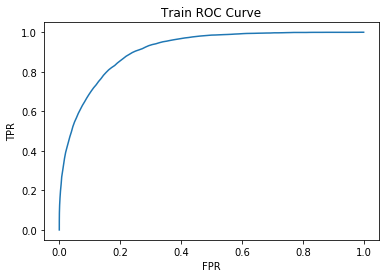

In [46]:
plt.plot(train_FPR, train_TPR)
plt.title('Train ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [47]:
training_summary.pr.show()

+-------------------+------------------+
|             recall|         precision|
+-------------------+------------------+
|                0.0|0.9961240310077519|
|0.04644018792916516|0.9961240310077519|
|0.08655583664618721|0.9876288659793815|
|0.12522587640043367| 0.973314606741573|
|0.16226960607155763|0.9563365282215123|
|0.19822912902059991|0.9408233276157805|
| 0.2325623418865197| 0.923905240488155|
| 0.2679797614745211|0.9154320987654321|
| 0.2992410552945428|0.8965890633459664|
|0.33068305023491146|0.8823529411764706|
| 0.3621250451752801|0.8709256844850065|
|0.39176002891217926|0.8575949367088608|
| 0.4185037947235273|0.8406533575317604|
|0.44488615829418143|0.8256203890006707|
| 0.4714492229851825|0.8130258647553755|
| 0.4963859775930611|0.7994761350407451|
| 0.5225876400433682|0.7895167895167895|
| 0.5462594868088182| 0.777120822622108|
| 0.5675822190097579|0.7629341753704153|
| 0.5896277556920853|0.7511510128913443|
+-------------------+------------------+
only showing top

In [48]:
train_recall = []
for each in training_summary.pr.select('recall').collect():
    train_recall.append(each['recall'])
    
train_precision = []
for each in training_summary.pr.select('precision').collect():
    train_precision.append(each['precision'])

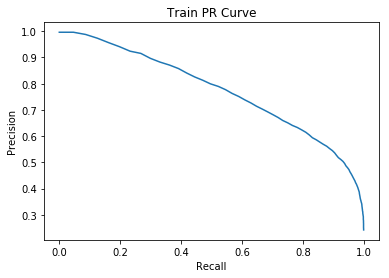

In [49]:
plt.plot(train_recall, train_precision)
plt.title('Train PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

## (4). Evaluation

In [50]:
test_summary = lr.evaluate(test_set)

In [51]:
print 'The value of area under ROC is ', test_summary.areaUnderROC

The value of area under ROC is  0.902686157789


**The value of area under ROC is  0.902686157789**.

In [52]:
print 'The accuracy is ', test_summary.accuracy

The accuracy is  0.849737735267


** The accuracy is  0.849737735267 (around 85%) **.

In [53]:
predictionAndLabels = test_summary.predictions

In [54]:
label_and_prediction = test_summary.predictions.select(['incomeIndex', 'prediction'])

In [55]:
TP = 0
FP = 0
FN = 0
TN = 0

for each_lab_pred in label_and_prediction.collect():
    if each_lab_pred[0] == 1.0 and each_lab_pred[1] == 1.0:
        TP += 1
    elif each_lab_pred[0] == 0.0 and each_lab_pred[1] == 1.0:
        FN += 1
    elif each_lab_pred[0] == 1.0 and each_lab_pred[1] == 0.0:
        FP += 1
    elif each_lab_pred[0] == 0.0 and each_lab_pred[1] == 0.0:
        TN += 1

In [56]:
confusion_matrix = np.array([[TP, FP], [TN, FN]])

In [57]:
print 'The confusion matrix is \n', confusion_matrix

The confusion matrix is 
[[1362  945]
 [6900  516]]


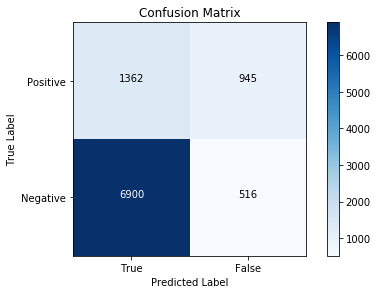

In [58]:
import itertools

state_label = ['Positive', 'Negative']
predi_label = ['True', 'False']

plt.title('Confusion Matrix')
plt.imshow(confusion_matrix, interpolation = 'nearest', cmap = 'Blues')
plt.colorbar()
plt.xticks(np.arange(2), predi_label)
plt.yticks(np.arange(2), state_label)

for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
    plt.text(j, i, format(confusion_matrix[i, j], 'd'),
             horizontalalignment = 'center', color = 'white' if confusion_matrix[i, j] > confusion_matrix.max() / 2 else 'black')

plt.tight_layout()

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()